In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

### 데이터 분석

In [3]:
train.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   418 non-null    int64  
 1   PassengerId  418 non-null    int64  
 2   Survived     418 non-null    int64  
 3   Pclass       418 non-null    int64  
 4   Name         418 non-null    object 
 5   Sex          418 non-null    object 
 6   Age          332 non-null    float64
 7   SibSp        418 non-null    int64  
 8   Parch        418 non-null    int64  
 9   Ticket       418 non-null    object 
 10  Fare         417 non-null    float64
 11  Cabin        91 non-null     object 
 12  Embarked     418 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 42.6+ KB


In [103]:
train['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [4]:
plt.style.use('ggplot')
sns.set()
sns.set_palette("Set2")

def chart(dataset, feature):
    survived = dataset[dataset['Survived'] == 1][feature].value_counts()
    dead = dataset[dataset['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True)

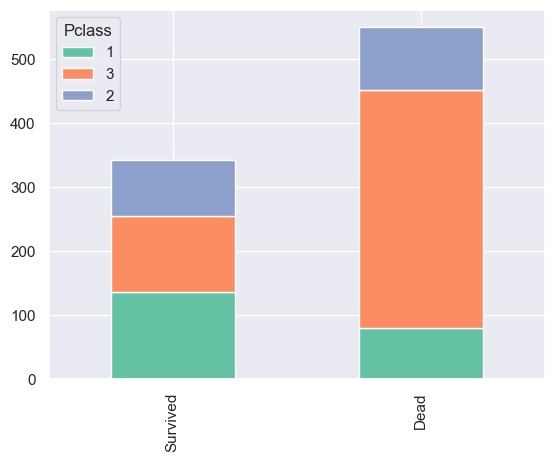

In [25]:
chart(train, 'Pclass')

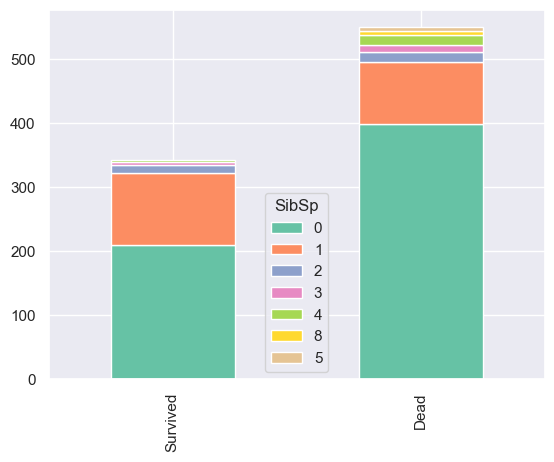

In [26]:
chart(train, 'SibSp')

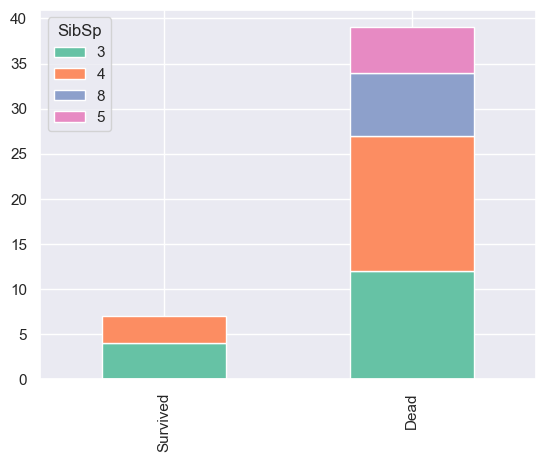

In [28]:
tmp = train[train['SibSp'] > 2]
chart(tmp, 'SibSp')

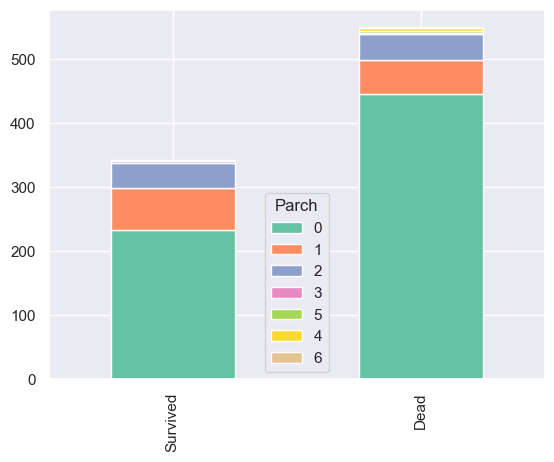

In [31]:
chart(train, 'Parch')

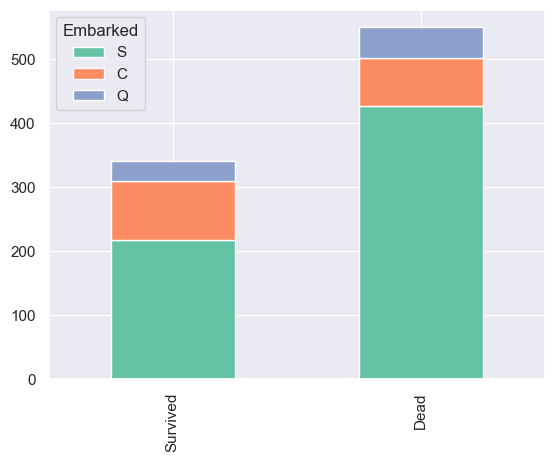

In [30]:
chart(train, 'Embarked')  # 생존율 : C > Q > S

In [62]:
tmp = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
tmp.value_counts()

Name
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

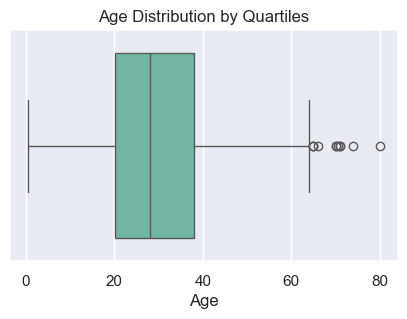

In [43]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=train, x='Age')
plt.title('Age Distribution by Quartiles')
plt.xlabel('Age')
plt.show()

## 전처리

In [3]:
sex = {'male':0, 'female':1}
prefix = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3}  # 나머지는 4
embarked = {'S':0, 'C':1, 'Q':2}

def preprocessing(df):
    df = df.copy()
    # df = df.set_index('PassengerId')
    df['Sex'] = df['Sex'].map(sex).astype(int)
    df['Prefix'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Prefix'] = df['Prefix'].map(prefix).fillna(4).astype(int)
    
    df['Age'] = df['Age'].fillna(df.groupby('Prefix')['Age'].transform('mean'))
    df['AgeCut'] = pd.qcut(df['Age'], 4, labels=[0, 1, 2, 3]).astype(int)
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
    df['FareCut'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)
    
    df = df.drop(columns=['Unnamed: 0', 'PassengerId', 'Name', 'Age', 'Fare', 'Ticket', 'Cabin'])
    df = df.dropna(subset=['Embarked'])
    df['Embarked'] = df['Embarked'].map(embarked).astype(int)
    
    return df


processed_train = preprocessing(train)
processed_test = preprocessing(test)

## 모델링

In [18]:
# F1 score가 최대가 되는 cutoff
def find_optimal_f1_cutoff(train_data, test_data, model, target_column='Survived'):
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    model.fit(X_train, y_train)

    model_name = type(model).__name__
    if model_name.startswith('Linear'):
        y_scores = model.predict(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    f1_scores = [f1_score(y_test, (y_scores >= thresh).astype(int)) for thresh in thresholds]
    
    optimal_cutoff = thresholds[np.argmax(f1_scores)]
    max_f1_score = max(f1_scores)

    print(f"Optimal cutoff: {optimal_cutoff:.2f}")
    print(f"F1 Score: {max_f1_score:.4f}")

    return optimal_cutoff


optimal_f1_cutoff_linear = find_optimal_f1_cutoff(processed_train, processed_test, LinearRegression())
optimal_f1_cutoff_logistic = find_optimal_f1_cutoff(processed_train, processed_test, LogisticRegression())

Optimal cutoff: 0.49
F1 Score: 0.7152
Optimal cutoff: 0.58
F1 Score: 0.7162


In [17]:
# Accuracy가 최대가 되는 cutoff
def find_optimal_accuracy_cutoff(train_data, test_data, model, target_column='Survived'):
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    model.fit(X_train, y_train)

    model_name = type(model).__name__
    if model_name.startswith('Linear'):
        y_scores = model.predict(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0, 1, 101)
    accuracy_scores = [accuracy_score(y_test, (y_scores >= thresh).astype(int)) for thresh in thresholds]
    
    optimal_cutoff = thresholds[np.argmax(accuracy_scores)]
    max_accuracy = max(accuracy_scores)

    print(f"Optimal cutoff: {optimal_cutoff:.2f}")
    print(f"Accuracy: {max_accuracy:.4f}")

    return optimal_cutoff


optimal_accuracy_cutoff_linear = find_optimal_accuracy_cutoff(processed_train, processed_test, LinearRegression())
optimal_accuracy_cutoff_logistic = find_optimal_accuracy_cutoff(processed_train, processed_test, LogisticRegression())

Optimal cutoff: 0.58
Accuracy: 0.7919
Optimal cutoff: 0.66
Accuracy: 0.7990


In [37]:
def regression_model(train_data, test_data, model, target_column='Survived', cutoff=0.5):
    model_name = type(model).__name__
    print(f'{model_name} Results')
    
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    model.fit(X_train, y_train)

    if model_name.startswith('Linear'):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred >= cutoff).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    for metric, score in results.items():
        print(f"- {metric}: {score:.4f}")
    print('-'*30)
    
    return [X_train, y_train]


results = regression_model(processed_train, processed_test, LinearRegression(), cutoff=optimal_f1_cutoff_linear)
_ = regression_model(processed_train, processed_test, LinearRegression(), cutoff=optimal_accuracy_cutoff_linear)
_ = regression_model(processed_train, processed_test, LogisticRegression(), cutoff=optimal_f1_cutoff_logistic)
_ = regression_model(processed_train, processed_test, LogisticRegression(), cutoff=optimal_accuracy_cutoff_logistic)

LinearRegression Results
- Accuracy: 0.7847
- Precision: 0.7152
- Recall: 0.7152
- F1 Score: 0.7152
------------------------------
LinearRegression Results
- Accuracy: 0.7919
- Precision: 0.7518
- Recall: 0.6709
- F1 Score: 0.7090
------------------------------
LogisticRegression Results
- Accuracy: 0.7990
- Precision: 0.7681
- Recall: 0.6709
- F1 Score: 0.7162
------------------------------
LogisticRegression Results
- Accuracy: 0.7990
- Precision: 0.8136
- Recall: 0.6076
- F1 Score: 0.6957
------------------------------


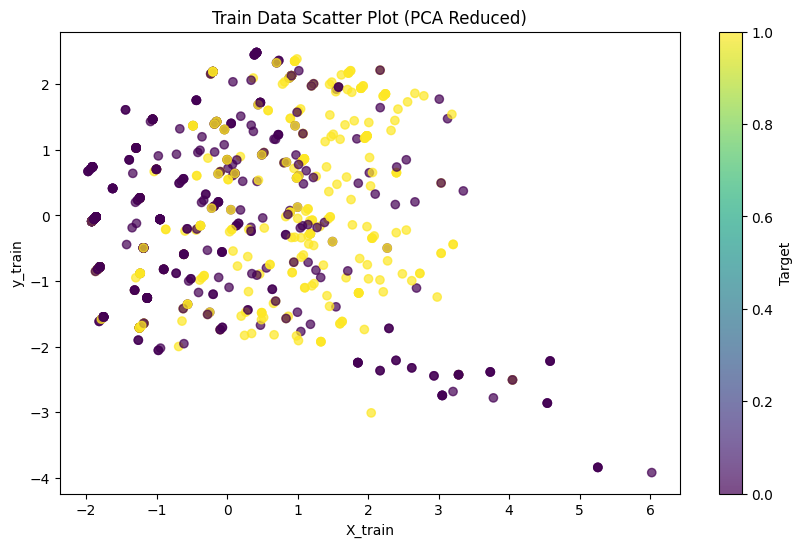

In [42]:
def plot_train_data(X_train, y_train):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Target')
    plt.xlabel("X_train")
    plt.ylabel("y_train")
    plt.title("Train Data Scatter Plot (PCA Reduced)")
    plt.show()
    

plot_train_data(*results)